# Fruits Dataset

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import time
import torch
import torch.nn as nn

# Definirea mediului pe care va rula codul de antrenare
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f'Running code @ {device}')

import numpy as np

# Plotting library.
from matplotlib import pyplot as plt
import pylab as pl
from IPython import display

import collections
import enum
import warnings
warnings.filterwarnings('ignore')

# Path to your zip file in Colab

zip_path = "/content/fruits-360_dataset_100x100.zip"
extract_path = "/content/"  # Destination folder

# Unzipping the file
!unzip -q "{zip_path}" -d "{extract_path}"

print(f"Files unzipped to {extract_path}")

Running code @ cuda
Files unzipped to /content/


# 3.1 MLP pe atributele extrase în etapa 1

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(p=0.2)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

Input size: 122
Hidden size: 128
Number of classes: 70
Epoch [1/25], Train Acc: 0.4213, Train Loss: 2.0977, Test Acc: 0.5383, Test Loss: 1.6759, Training Speed: 19830.59 samples/sec
Epoch [2/25], Train Acc: 0.6313, Train Loss: 1.1997, Test Acc: 0.6085, Test Loss: 1.4175, Training Speed: 23482.57 samples/sec
Epoch [3/25], Train Acc: 0.7115, Train Loss: 0.9175, Test Acc: 0.6548, Test Loss: 1.2386, Training Speed: 23251.62 samples/sec
Epoch [4/25], Train Acc: 0.7522, Train Loss: 0.7714, Test Acc: 0.6959, Test Loss: 1.1507, Training Speed: 19575.09 samples/sec
Epoch [5/25], Train Acc: 0.7850, Train Loss: 0.6711, Test Acc: 0.7038, Test Loss: 1.1329, Training Speed: 23091.01 samples/sec
Epoch [6/25], Train Acc: 0.8024, Train Loss: 0.6091, Test Acc: 0.7146, Test Loss: 1.1002, Training Speed: 23511.24 samples/sec
Epoch [7/25], Train Acc: 0.8207, Train Loss: 0.5559, Test Acc: 0.7191, Test Loss: 1.1059, Training Speed: 23544.85 samples/sec
Epoch [8/25], Train Acc: 0.8317, Train Loss: 0.5191, Tes

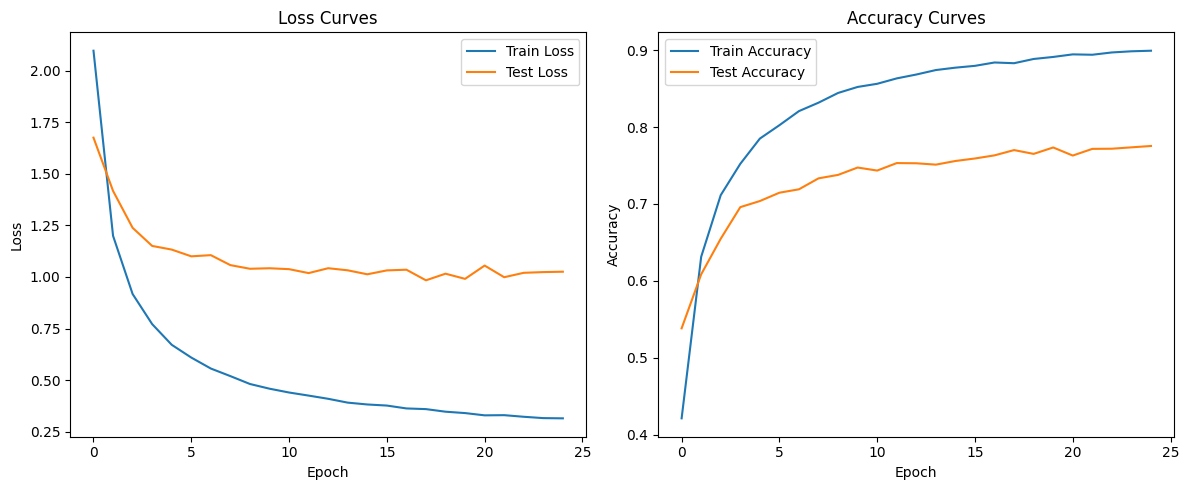

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import SelectPercentile, f_classif

# Încărcarea datelor preprocesate
npzfile = np.load('/content/transformed_data_fruits_2.npz')
X_train = npzfile['X_train_selected']
X_test = npzfile['X_test_selected']
y_train = npzfile['y_train']
y_test = npzfile['y_test']

percentile = 9
selector = SelectPercentile(score_func=f_classif, percentile=percentile)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Parametri model
input_size = X_train_selected.shape[1]
hidden_size = 128
num_classes = len(np.unique(y_train))
num_epochs = 25
batch_size = 64
learning_rate = 0.001
training_speeds = []
total_samples = 0
total_training_time = 0

print(f"Input size: {input_size}")
print(f"Hidden size: {hidden_size}")
print(f"Number of classes: {num_classes}")

# Pregătirea datelor pentru PyTorch
def convert_to_tensor(X, y):
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.long)
    return X_tensor, y_tensor

X_train_tensor, y_train_tensor = convert_to_tensor(X_train_selected, y_train)
X_test_tensor, y_test_tensor = convert_to_tensor(X_test_selected, y_test)

# Crearea DataLoader-ului pentru antrenament și test
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Inițializarea modelului, funcției de pierdere și optimizatorului
model = MLP(input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Antrenarea modelului
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    correct, total = 0, 0
    start_time = time.time()
    if torch.cuda.is_available():
          torch.cuda.synchronize()

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metrici
        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    if torch.cuda.is_available():
            torch.cuda.synchronize()
    end_time = time.time()
    epoch_duration = end_time - start_time
    samples_per_second = total / epoch_duration
    training_speeds.append(samples_per_second)
    total_training_time += epoch_duration
    total_samples += total
    train_losses.append(epoch_loss / len(train_loader))
    train_accuracies.append(correct / total)

    # Evaluare pe setul de test
    model.eval()
    test_loss, correct, total = 0, 0, 0

    # liste pentru a stoca predicțiile și etichetele reale
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # stocarea predicțiilor și a etichetelor reale
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(correct / total)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
      f"Train Acc: {train_accuracies[-1]:.4f}, Train Loss: {train_losses[-1]:.4f}, "
      f"Test Acc: {test_accuracies[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, "
      f"Training Speed: {samples_per_second:.2f} samples/sec")

# Calculare si display total_training_speed
total_training_speed = total_samples / total_training_time
print(f"Total Training Speed: {total_training_speed:.2f} samples/sec")
print(f"Total Training Time for Fashion-MNIST: {total_training_time:.2f} sec")

# Calcularea metricilor de performanță
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print("\nMetrici de Performanță:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return accuracy, precision, recall, f1

# Adăugat: Apelarea funcției pentru metrici
accuracy, precision, recall, f1 = calculate_metrics(all_labels, all_preds)

# Plotarea curbelor de pierdere și acuratețe
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves')

plt.tight_layout()
plt.show()


# 3.2  Arhitectura de tip MLP direct peste imagini

In [ ]:
import torchvision
import torchvision.transforms as transforms

# 1. Pregătirea datelor
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Lambda(lambda x: x.view(-1))
])

train_dataset_fruits = torchvision.datasets.ImageFolder(root='/content/fruits-360/Training', transform=transform)
test_dataset_fruits = torchvision.datasets.ImageFolder(root='/content/fruits-360/Test', transform=transform)


In [ ]:
# define dimension of the batches to sample from the datasets
BATCH_SIZE_TRAIN = 64  #@param
BATCH_SIZE_TEST = 64  #@param
NO_WORKERS = 8  #@param
SHUFFLE_DATA = True

# create Dataset iterator object using the data previously downloaded
# we shuffle the data and sample repeatedly batches for training
train_loader = torch.utils.data.DataLoader(train_dataset_fruits, batch_size=BATCH_SIZE_TRAIN,
                                           shuffle=SHUFFLE_DATA,
                                           num_workers=NO_WORKERS)

# get a training batch of images and labels
(batch_train_images, batch_train_labels) = next(iter(train_loader))

# check that the shape of the training batches is the expected one
print(f'Shape of training images: {batch_train_images.size()}')
print(f'Shape of training labels: {batch_train_labels.size()}')

# we do the same for test dataset
test_loader = torch.utils.data.DataLoader(test_dataset_fruits, batch_size=BATCH_SIZE_TRAIN,
                                          shuffle=SHUFFLE_DATA,
                                          num_workers=NO_WORKERS)

(batch_test_images, batch_test_labels) = next(iter(test_loader))
print(f'Shape of test images: {batch_test_images.size()}')
print(f'Shape of test labels: {batch_test_labels.size()}')

Shape of training images: torch.Size([64, 3072])
Shape of training labels: torch.Size([64])
Shape of test images: torch.Size([64, 3072])
Shape of test labels: torch.Size([64])


# Clasa MLP

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(p=0.5)
        self.dropout2 = nn.Dropout(p=0.3)
        self.dropout3 = nn.Dropout(p=0.1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.relu(self.fc3(x))
        x = self.dropout3(x)
        x = self.fc4(x)
        return x


Epoch 1/25, Train Loss: 1.8593, Train Acc: 0.4592, Test Loss: 0.8092, Test Acc: 0.7720, Training Speed: 1401.66 samples/sec
Epoch 2/25, Train Loss: 0.8942, Train Acc: 0.7117, Test Loss: 0.6068, Test Acc: 0.8088, Training Speed: 1567.46 samples/sec
Epoch 3/25, Train Loss: 0.6993, Train Acc: 0.7710, Test Loss: 0.5018, Test Acc: 0.8507, Training Speed: 1470.29 samples/sec
Epoch 4/25, Train Loss: 0.6094, Train Acc: 0.8032, Test Loss: 0.4364, Test Acc: 0.8687, Training Speed: 1551.30 samples/sec
Epoch 5/25, Train Loss: 0.5570, Train Acc: 0.8204, Test Loss: 0.4456, Test Acc: 0.8779, Training Speed: 1524.21 samples/sec
Epoch 6/25, Train Loss: 0.5143, Train Acc: 0.8334, Test Loss: 0.3910, Test Acc: 0.8795, Training Speed: 1551.80 samples/sec
Epoch 7/25, Train Loss: 0.4854, Train Acc: 0.8443, Test Loss: 0.3728, Test Acc: 0.8926, Training Speed: 1488.89 samples/sec
Epoch 8/25, Train Loss: 0.4660, Train Acc: 0.8514, Test Loss: 0.3650, Test Acc: 0.8932, Training Speed: 1549.79 samples/sec
Epoch 9/

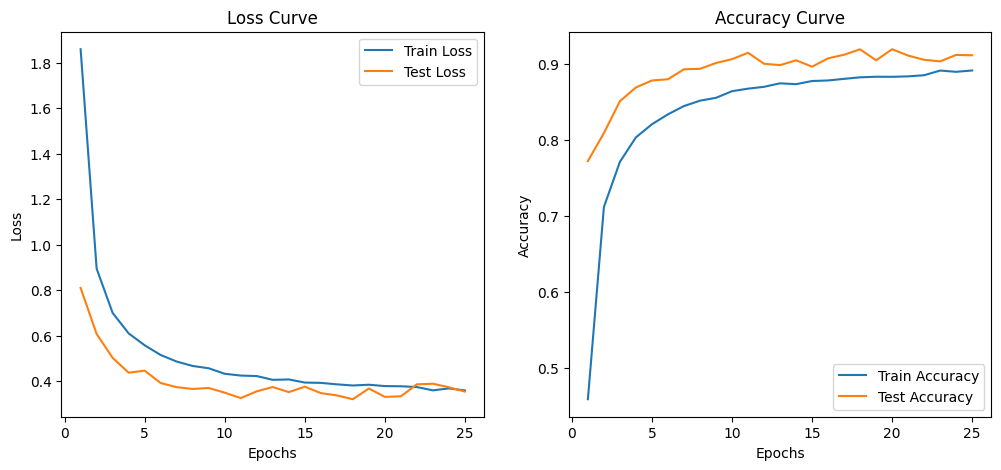

In [ ]:
# Initialize model, loss function, and optimizer
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
hidden_size = 256
input_size = 3*32*32  # 32x32 images
num_classes = len(train_dataset_fruits.classes)
model = MLP(input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training settings
num_epochs = 25
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
training_speeds = []
total_samples = 0
total_training_time = 0

# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    correct, total = 0, 0
    start_time = time.time()
    if torch.cuda.is_available():
          torch.cuda.synchronize()

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metrics
        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    if torch.cuda.is_available():
            torch.cuda.synchronize()
    end_time = time.time()
    epoch_duration = end_time - start_time
    samples_per_second = total / epoch_duration
    training_speeds.append(samples_per_second)
    total_training_time += epoch_duration
    total_samples += total
    train_losses.append(epoch_loss / len(train_loader))
    train_accuracies.append(correct / total)

    # Evaluation loop
    model.eval()
    test_loss, correct, total = 0, 0, 0
    # liste pentru a stoca predicțiile și etichetele reale

    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # stocarea predicțiilor și a etichetelor reale
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(correct / total)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, "
          f"Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_accuracies[-1]:.4f}, "
          f"Training Speed: {samples_per_second:.2f} samples/sec")

# Calculare si display total training speed
total_training_speed = total_samples / total_training_time
print(f"Total Training Speed: {total_training_speed:.2f} samples/sec")
print(f"Total Training Time for Fashion-MNIST: {total_training_time:.2f} sec")

# Calcularea metricilor de performanță
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print("\nMetrici de Performanță:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return accuracy, precision, recall, f1

# Apelarea funcției pentru metrici
accuracy, precision, recall, f1 = calculate_metrics(all_labels, all_preds)


# Plot loss and accuracy curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')

plt.show()

# 3.3 Arhitectura de tip convoluțional

In [2]:
import torchvision
import torchvision.transforms as transforms

# 1. Pregătirea datelor
transform_no_aug = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

transform_aug = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(size=100, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

train_dataset_fruits_no_aug = torchvision.datasets.ImageFolder(root='/content/fruits-360/Training', transform=transform_no_aug)
train_dataset_fruits_aug = torchvision.datasets.ImageFolder(root='/content/fruits-360/Training', transform=transform_aug)
test_dataset_fruits = torchvision.datasets.ImageFolder(root='/content/fruits-360/Test', transform=transform_no_aug)


In [3]:
# define dimension of the batches to sample from the datasets
BATCH_SIZE_TRAIN = 64  #@param
BATCH_SIZE_TEST = 64  #@param
NO_WORKERS = 8  #@param
SHUFFLE_DATA = True

train_loader_no_aug = torch.utils.data.DataLoader(train_dataset_fruits_no_aug, batch_size=BATCH_SIZE_TRAIN,
                                           shuffle=SHUFFLE_DATA,
                                           num_workers=NO_WORKERS)
train_loader_aug = torch.utils.data.DataLoader(train_dataset_fruits_aug, batch_size=BATCH_SIZE_TRAIN,
                                           shuffle=SHUFFLE_DATA,
                                           num_workers=NO_WORKERS)
test_loader = torch.utils.data.DataLoader(test_dataset_fruits, batch_size=BATCH_SIZE_TRAIN,
                                           shuffle=SHUFFLE_DATA,
                                           num_workers=NO_WORKERS)

# get a training batch of images and labels
(batch_train_no_aug_images, batch_train_labels) = next(iter(train_loader_no_aug))

# check that the shape of the training batches is the expected one
print(f'Shape of training images: {batch_train_no_aug_images.size()}')
print(f'Shape of training labels: {batch_train_labels.size()}')

# get a training batch of images and labels
(batch_train_images, batch_train_labels) = next(iter(train_loader_aug))

# check that the shape of the training batches is the expected one
print(f'Shape of training images: {batch_train_images.size()}')
print(f'Shape of training labels: {batch_train_labels.size()}')

# get a training batch of images and labels
(batch_test_images, batch_test_labels) = next(iter(test_loader))
print(f'Shape of test images: {batch_test_images.size()}')
print(f'Shape of test labels: {batch_test_labels.size()}')

Shape of training images: torch.Size([64, 3, 100, 100])
Shape of training labels: torch.Size([64])
Shape of training images: torch.Size([64, 3, 100, 100])
Shape of training labels: torch.Size([64])
Shape of test images: torch.Size([64, 3, 100, 100])
Shape of test labels: torch.Size([64])


In [4]:
class FruitsCNN(nn.Module):
    def __init__(self):
        super(FruitsCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, len(train_dataset_fruits_no_aug.classes))  # Number of output classes
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.global_pool(x)
        x = self.fc_layers(x)
        return x

Epoch [1/25]
No Augmentation: Train Loss: 1.0305, Train Acc: 0.8231, Test Loss: 0.2341, Test Acc: 0.9529, Train Speed: 1019.31 samples/sec

Metrici pentru No Augmentation:
Accuracy: 0.9529
Precision: 0.9650
Recall: 0.9529
F1 Score: 0.9493
With Augmentation: Train Loss: 1.1244, Train Acc: 0.7859, Test Loss: 0.4087, Test Acc: 0.8946, Train Speed: 640.98 samples/sec

Metrici pentru With Augmentation:
Accuracy: 0.8946
Precision: 0.9126
Recall: 0.8946
F1 Score: 0.8863
Epoch [2/25]
No Augmentation: Train Loss: 0.1029, Train Acc: 0.9859, Test Loss: 0.1297, Test Acc: 0.9688, Train Speed: 1108.69 samples/sec

Metrici pentru No Augmentation:
Accuracy: 0.9688
Precision: 0.9737
Recall: 0.9688
F1 Score: 0.9680
With Augmentation: Train Loss: 0.1693, Train Acc: 0.9668, Test Loss: 0.1736, Test Acc: 0.9567, Train Speed: 653.56 samples/sec

Metrici pentru With Augmentation:
Accuracy: 0.9567
Precision: 0.9618
Recall: 0.9567
F1 Score: 0.9556
Epoch [3/25]
No Augmentation: Train Loss: 0.0473, Train Acc: 0.9

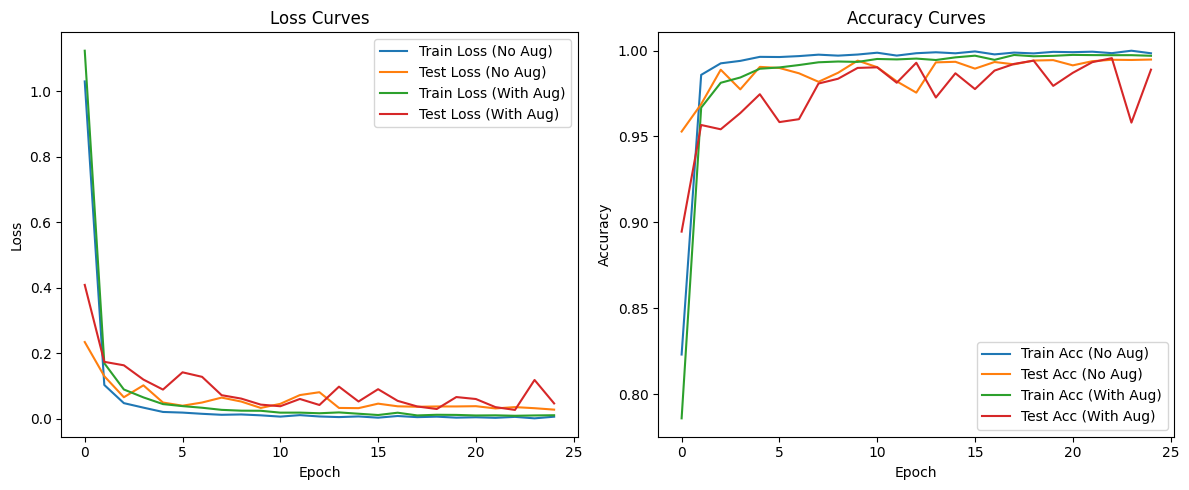

In [5]:
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
num_epochs = 25
batch_size = 64
learning_rate = 0.001

# Initialize models, loss function, and optimizers
model_no_aug = FruitsCNN().to(device)
model_with_aug = FruitsCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer_no_aug = torch.optim.Adam(model_no_aug.parameters(), lr=learning_rate)
optimizer_with_aug = torch.optim.Adam(model_with_aug.parameters(), lr=learning_rate)

# Training and evaluation loop with time and speed measurements
history = {'no_aug': {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': [], 'train_speed': []},
           'with_aug': {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': [], 'train_speed': []}}

total_training_time_no_aug, total_training_time_with_aug = 0, 0

# Funcție pentru calcularea și afișarea metricilor
def calculate_metrics(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"\nMetrici pentru {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

def train_model(model, train_loader, optimizer):
    model.train()
    total_loss, correct = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()

    return total_loss / len(train_loader), correct / len(train_loader.dataset)

def evaluate_model(model, test_loader):
    model.eval()
    all_preds_no_aug, all_labels_no_aug = [], []
    total_loss, correct = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            all_preds_no_aug.extend(predicted.cpu().numpy())
            all_labels_no_aug.extend(labels.cpu().numpy())

    return total_loss / len(test_loader), correct / len(test_loader.dataset), all_preds_no_aug, all_labels_no_aug

for epoch in range(num_epochs):
    print(f'Epoch [{epoch+1}/{num_epochs}]')

    # model without augmentations
    model_no_aug.train()
    start_time = time.time()
    train_loss, train_acc = train_model(model_no_aug, train_loader_no_aug, optimizer_no_aug)
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    end_time = time.time()
    epoch_duration = end_time - start_time
    train_speed = len(train_loader_no_aug.dataset) / epoch_duration
    total_training_time_no_aug += epoch_duration
    history['no_aug']['train_speed'].append(train_speed)

    test_loss, test_acc, all_preds_no_aug, all_labels_no_aug = evaluate_model(model_no_aug, test_loader)
    history['no_aug']['train_loss'].append(train_loss)
    history['no_aug']['train_acc'].append(train_acc)
    history['no_aug']['test_loss'].append(test_loss)
    history['no_aug']['test_acc'].append(test_acc)

    print(f"No Augmentation: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}, "
          f"Train Speed: {train_speed:.2f} samples/sec")
    calculate_metrics(all_labels_no_aug, all_preds_no_aug, 'No Augmentation')

    # model with augmentations
    model_with_aug.train()
    start_time = time.time()
    train_loss, train_acc = train_model(model_with_aug, train_loader_aug, optimizer_with_aug)
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    end_time = time.time()
    epoch_duration = end_time - start_time
    train_speed = len(train_loader_aug.dataset) / epoch_duration
    total_training_time_with_aug += epoch_duration
    history['with_aug']['train_speed'].append(train_speed)

    test_loss, test_acc, all_preds_no_aug, all_labels_no_aug = evaluate_model(model_with_aug, test_loader)
    history['with_aug']['train_loss'].append(train_loss)
    history['with_aug']['train_acc'].append(train_acc)
    history['with_aug']['test_loss'].append(test_loss)
    history['with_aug']['test_acc'].append(test_acc)

    print(f"With Augmentation: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}, "
          f"Train Speed: {train_speed:.2f} samples/sec")
    calculate_metrics(all_labels_no_aug, all_preds_no_aug, 'With Augmentation')

print(f"Total Training Time for No Augmentation: {total_training_time_no_aug:.2f} sec")
print(f"Total Training Time for With Augmentation: {total_training_time_with_aug:.2f} sec")

# Plot loss and accuracy curves
plt.figure(figsize=(12, 5))

# Loss curves
plt.subplot(1, 2, 1)
plt.plot(history['no_aug']['train_loss'], label='Train Loss (No Aug)')
plt.plot(history['no_aug']['test_loss'], label='Test Loss (No Aug)')
plt.plot(history['with_aug']['train_loss'], label='Train Loss (With Aug)')
plt.plot(history['with_aug']['test_loss'], label='Test Loss (With Aug)')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy curves
plt.subplot(1, 2, 2)
plt.plot(history['no_aug']['train_acc'], label='Train Acc (No Aug)')
plt.plot(history['no_aug']['test_acc'], label='Test Acc (No Aug)')
plt.plot(history['with_aug']['train_acc'], label='Train Acc (With Aug)')
plt.plot(history['with_aug']['test_acc'], label='Test Acc (With Aug)')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# 3.4. Utilizarea unei proceduri de finetuning peste arhitectura ResNet-18

In [ ]:
import time
# Training and evaluation loop
def train_model(model, train_loader, test_loader, num_epochs):
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []
    training_speeds = []
    total_samples = 0
    total_training_time = 0

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        correct, total = 0, 0
        start_time = time.time()
        if torch.cuda.is_available():
          torch.cuda.synchronize()

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Metrics
            epoch_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        if torch.cuda.is_available():
            torch.cuda.synchronize()
        end_time = time.time()
        epoch_duration = end_time - start_time
        samples_per_second = total / epoch_duration
        training_speeds.append(samples_per_second)
        total_training_time += epoch_duration
        total_samples += total

        train_losses.append(epoch_loss / len(train_loader))
        train_accuracies.append(correct / total)

        # Evaluation loop
        model.eval()
        test_loss, correct, total = 0, 0, 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        test_losses.append(test_loss / len(test_loader))
        test_accuracies.append(correct / total)

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, "
              f"Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_accuracies[-1]:.4f}, "
              f"Training Speed: {samples_per_second:.2f} samples/sec")

        scheduler.step()

    return train_losses, test_losses, train_accuracies, test_accuracies, total_training_time, total_samples

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 171MB/s]


Epoch 1/25, Train Loss: 0.3677, Train Acc: 0.9377, Test Loss: 0.1378, Test Acc: 0.9656, Training Speed: 1181.90 samples/sec
Epoch 2/25, Train Loss: 0.0163, Train Acc: 0.9988, Test Loss: 0.1061, Test Acc: 0.9734, Training Speed: 1211.52 samples/sec
Epoch 3/25, Train Loss: 0.0078, Train Acc: 0.9996, Test Loss: 0.0896, Test Acc: 0.9780, Training Speed: 1230.47 samples/sec
Epoch 4/25, Train Loss: 0.0054, Train Acc: 0.9998, Test Loss: 0.0866, Test Acc: 0.9780, Training Speed: 1212.34 samples/sec
Epoch 5/25, Train Loss: 0.0042, Train Acc: 0.9997, Test Loss: 0.0831, Test Acc: 0.9789, Training Speed: 1214.39 samples/sec
Epoch 6/25, Train Loss: 0.0034, Train Acc: 0.9999, Test Loss: 0.0843, Test Acc: 0.9786, Training Speed: 1201.38 samples/sec
Epoch 7/25, Train Loss: 0.0032, Train Acc: 0.9998, Test Loss: 0.0848, Test Acc: 0.9782, Training Speed: 1235.57 samples/sec
Epoch 8/25, Train Loss: 0.0030, Train Acc: 0.9999, Test Loss: 0.0836, Test Acc: 0.9790, Training Speed: 1231.85 samples/sec
Epoch 9/

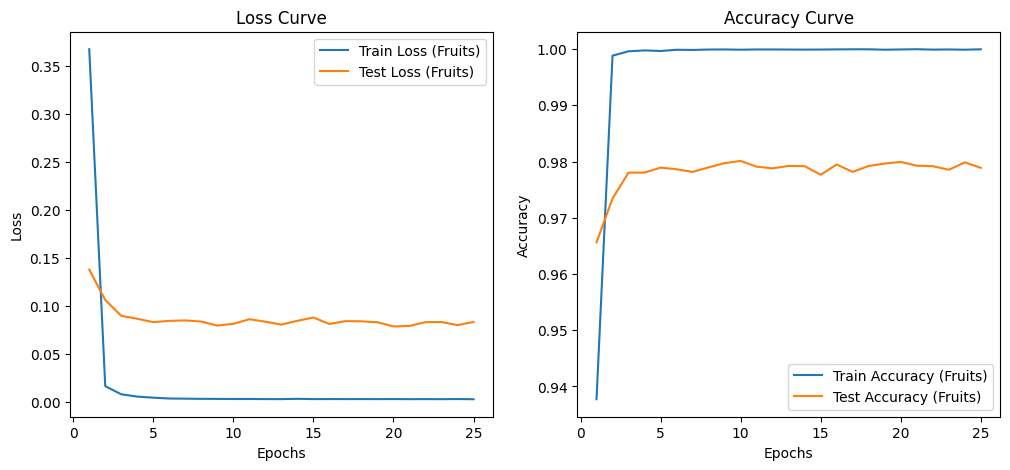

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Hyperparameters
num_epochs = 25
batch_size = 64
learning_rate = 0.001
NO_WORKERS = 8

transform_fruits360 = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset_fruits = datasets.ImageFolder(root='/content/fruits-360/Training', transform=transform_fruits360)
test_dataset_fruits = datasets.ImageFolder(root='/content/fruits-360/Test', transform=transform_fruits360)

train_loader_fruits = DataLoader(train_dataset_fruits, batch_size=batch_size, shuffle=True, num_workers=NO_WORKERS)
test_loader_fruits = DataLoader(test_dataset_fruits, batch_size=batch_size, shuffle=False, num_workers=NO_WORKERS)

# Load pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)
num_fruits_classes = len(train_dataset_fruits.classes)
model.fc = nn.Linear(model.fc.in_features, num_fruits_classes)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Training for Fruits
train_losses_fruits, test_losses_fruits, train_accuracies_fruits, test_accuracies_fruits, total_time_fruits, total_samples_fruits = train_model(model, train_loader_fruits, test_loader_fruits, num_epochs)

# Calculate and display total training speed
training_speed_fruits = total_samples_fruits / total_time_fruits
print(f"Total Training Speed for Fruits: {training_speed_fruits:.2f} samples/sec")
print(f"Total Training Time for Fruits: {total_time_fruits:.2f} sec")

# Calcularea metricilor de performanță
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print("\nMetrici de Performanță:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return accuracy, precision, recall, f1

# Extracția predicțiilor și a etichetelor reale
def extract_predictions(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_labels, all_preds

# Calcularea și afișarea metricilor
y_true, y_pred = extract_predictions(model, test_loader_fruits)
calculate_metrics(y_true, y_pred)

# Plotting the results
plt.figure(figsize=(12, 5))

# Loss Curves
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses_fruits, label='Train Loss (Fruits)')
plt.plot(range(1, num_epochs+1), test_losses_fruits, label='Test Loss (Fruits)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

# Accuracy Curves
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies_fruits, label='Train Accuracy (Fruits)')
plt.plot(range(1, num_epochs+1), test_accuracies_fruits, label='Test Accuracy (Fruits)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')

plt.show()

